# Android Malware Detection

## Importing the required packages

In [2]:
import os
import math
import joblib
import warnings
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score
warnings.filterwarnings("ignore")
from IPython.core.display import HTML

## Loading the dataset

We read from the csv and load it into a variable in order to perform exploratory data analysis and train a model

In [3]:
class Dataset:

    def __init__(self, data_path):
        self.data_path = data_path
        self.data = None

    def load_data(self):
        csv_data = pd.read_csv(self.data_path, sep=";")
        self.data = csv_data
        return self.data


## Performing Exploratory Analysis on the data

Here we have defined functions to 

<ol>
    <li>Check for missing values</li>
    <li>Perform principal component analysis (PCA) to check the spread of the dependent variable type between 2 components</li>
    <li>Check for most permissions given by type</li>
    <li>Check whether the dataset is balanced or imbalanced</li>
    <li>Check the correlation between different columns</li>
    <li>Remove columns which are correlated above a configurable threshold</li>
</ol>

In [61]:
class ExploratoryAnalysis:

    def __init__(self):
        self.data = Dataset("Dataset.csv").load_data()
        self.X = data.loc[:, data.columns != "type"]
        self.y = data.loc[:, data.columns == "type"]

    def analyse_missing_values(self):
        print("Missing values in the dataset is", self.data.isna().sum().sum())
        
    def perform_pca(self):
        pca_android_malware = PCA(2)  # project from 64 to 2 dimensions
        projected = pca_android_malware.fit_transform(self.X)
        print("Variance between the components", pca_android_malware.explained_variance_)
        plt.scatter(projected[:, 0], projected[:, 1],
                    c=self.data.type, edgecolor='none', alpha=0.5,
                    cmap=plt.cm.get_cmap('Spectral', 10))
        plt.xlabel('component 1')
        plt.ylabel('component 2')
        plt.colorbar();
        
    def most_permissions_given(self):
        fig, axs =  plt.subplots(nrows=1)
        print("Most permissions given where type is Malicious")
        print(pd.Series.sort_values(self.data[self.data.type==1].sum(axis=0), ascending=False)[1:11])
        pd.Series.sort_values(self.data[self.data.type==1].sum(axis=0), ascending=False)[1:11].plot.bar(ax=axs, color="red")
        figs, axss =  plt.subplots(nrows=1)
        print("Most permissions given where type is Benign")
        print(pd.Series.sort_values(self.data[self.data.type==0].sum(axis=0), ascending=False)[:10])
        pd.Series.sort_values(self.data[self.data.type==0].sum(axis=0), ascending=False)[:10].plot.bar(ax=axss)
        plt.show()
        
    def distribution_type(self):
        fig, axs =  plt.subplots(nrows=1, sharex=True)
        self.data.type.value_counts().plot.bar(ax=axs, title="Distribution between Malicious and Benign")
        plt.show()

    def correlation(self):
        corr_matrix = self.data.corr()
        f, ax = plt.subplots(figsize=(10, 8))
        dataplot = sns.heatmap(corr_matrix)
        plt.gca().axes.get_xaxis().set_visible(False)
        plt.gca().axes.get_yaxis().set_visible(False)
        plt.show()
    
    def remove_correlated_columns(self, threshold):
        col_corr = set()
        corr_matrix = self.data.corr()
        for i in range(len(corr_matrix.columns)):
            for j in range(i):
                if (corr_matrix.iloc[i, j] >= threshold) and (corr_matrix.columns[j] not in col_corr):
                    colname = corr_matrix.columns[i]
                    if colname != "type":
                        col_corr.add(colname)
                        if colname in self.data.columns:
                            del self.data[colname]
        print("Number of columns with greater than " + str(threshold) + " correlation are", len(col_corr))
        print("Columns with greater than " + str(threshold) + " correlation are", col_corr)                            
        return self.data

## Analysing data for missing values

Here we can see that the missing values across the complete dataset is 0.

In [62]:
eda = ExploratoryAnalysis()
eda.analyse_missing_values()

Missing values in the dataset is 0


## Checking whether the dataset is balanced or imbalanced

Based on the distribution of the dependent variable, we can see that the dataset is perfectly balanced.

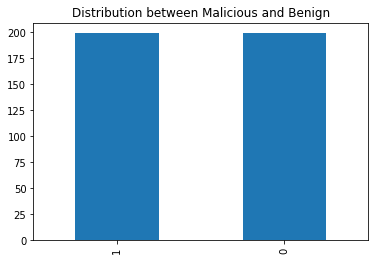

In [25]:
eda.distribution_type()

## Performing PCA

When we plot the 2 components along with the different labels in dependent variable, can observe the 2 classes benign and malicious when projected to a 2-D space are separable to a certain extent.

Variance between the components [1.40738585 0.7913164 ]


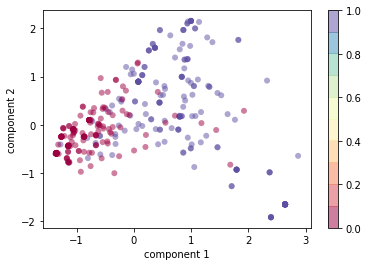

In [63]:
eda.perform_pca()

## Top 10 permissions given for each type

We have plotted the top 10 permissions for each label in dependent variable. We can see that there is a 50% overlap in the top 10 categories for each type.

Most permissions given where type is Malicious
android.permission.INTERNET                  195
android.permission.READ_PHONE_STATE          190
android.permission.ACCESS_NETWORK_STATE      167
android.permission.WRITE_EXTERNAL_STORAGE    136
android.permission.ACCESS_WIFI_STATE         135
android.permission.READ_SMS                  124
android.permission.WRITE_SMS                 104
android.permission.RECEIVE_BOOT_COMPLETED    102
android.permission.ACCESS_COARSE_LOCATION     80
android.permission.CHANGE_WIFI_STATE          75
dtype: int64
Most permissions given where type is Benign
android.permission.INTERNET                  104
android.permission.WRITE_EXTERNAL_STORAGE     76
android.permission.ACCESS_NETWORK_STATE       62
android.permission.WAKE_LOCK                  36
android.permission.RECEIVE_BOOT_COMPLETED     30
android.permission.ACCESS_WIFI_STATE          29
android.permission.READ_PHONE_STATE           24
android.permission.VIBRATE                    21
android.permis

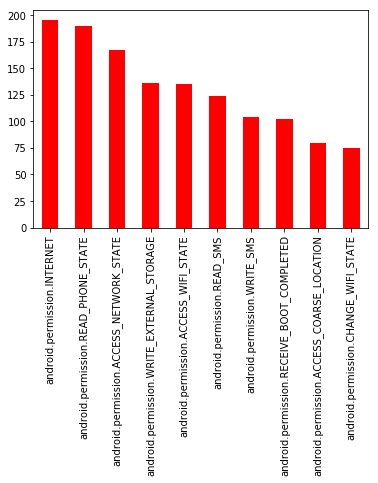

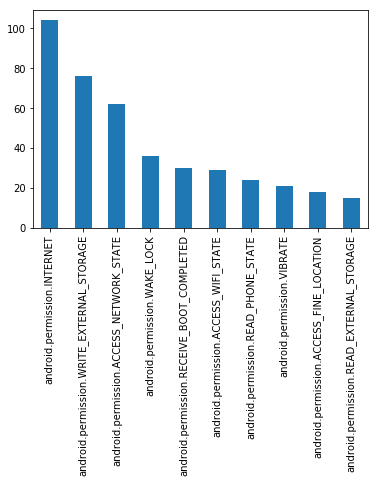

In [8]:
eda.most_permissions_given()

## Performing correlation check between all columns

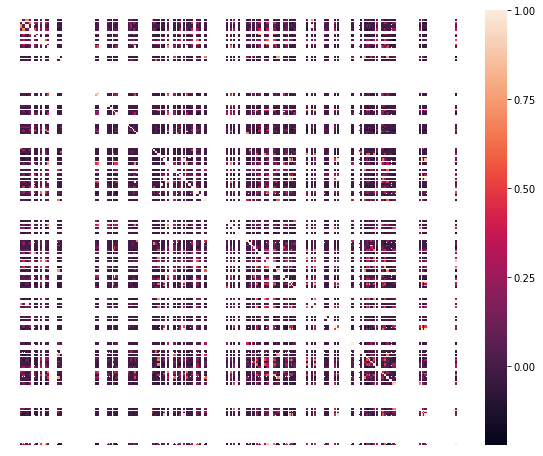

In [9]:
eda.correlation()

## Importing required packages for Feature Engineering

In [30]:
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.ensemble import ExtraTreesClassifier

## Feature Engineering

Here we have implemented the 2 feature engineering approaches. The first technique removes correlated columns above 0.4 threshold and then performs sklearn feature selection to select the top features. The second technique removes correlated columns above 0.6 threshold and then performs ExtraTreesClassifier to select the important features.

In [28]:
class FeatureEngineering:
    
    def __init__(self):
        self.data = Dataset("Dataset.csv").load_data()
        self.X = self.data.loc[:, self.data.columns != "type"]
        self.y = self.data.loc[:, self.data.columns == "type"]
        
    def feature_engineering_one(self):
        eda = ExploratoryAnalysis()
        eda.remove_correlated_columns(0.4)
        best_features = SelectKBest(score_func=chi2)
        fit = best_features.fit(self.X, self.y)
        df_scores = pd.DataFrame(fit.scores_)
        df_columns = pd.DataFrame(self.X.columns)
        feature_scores = pd.concat([df_columns, df_scores], axis=1)
        feature_scores.columns = ["Specs", "Scores"]
        print("\n Top 10 important features are \n", feature_scores.nlargest(10, 'Scores'))
        ax = feature_scores.nlargest(10, 'Scores').plot(kind="barh")
        ax.set_yticklabels(feature_scores.nlargest(10, 'Scores')["Specs"], rotation=0)
        for feature_column in feature_scores.iterrows():
            if feature_column[1]["Scores"] == 0 or math.isnan(feature_column[1]["Scores"]) == True:
                del self.data[feature_column[1]["Specs"]]
        return self.data
        
    def feature_engineering_two(self):
        eda = ExploratoryAnalysis()
        eda.remove_correlated_columns(0.6)
        model = ExtraTreesClassifier()
        model.fit(self.X, self.y)
        feat_importances = pd.Series(model.feature_importances_, index=self.X.columns)
        print("\n Top 10 important features are \n", feat_importances.nlargest(10))
        feat_importances.nlargest(10).plot(kind="barh")
        for feature, feature_score in feat_importances.items():
            if feature_score == 0:
                del self.data[feature]
        return self.data


## Analysing the results of Feature Engineering 1

In the first technique, we see that 57 columns having greater than 0.4 correlation are removed. And there are 88 columns left from initial 330 columns after selecting the top important features.

Number of columns with greater than 0.4 correlation are 57
Columns with greater than 0.4 correlation are {'android.permission.DEVICE_POWER', 'android.permission.RECORD_AUDIO', 'android.permission.BLUETOOTH_ADMIN', 'android.permission.FLASHLIGHT', 'android.permission.WRITE_SYNC_SETTINGS', 'android.permission.SEND_SMS', 'com.android.launcher.permission.INSTALL_SHORTCUT', 'android.permission.READ_LOGS', 'android.permission.MODIFY_PHONE_STATE', 'android.permission.READ_SYNC_SETTINGS', 'android.permission.RECEIVE_MMS', 'com.android.launcher.permission.UNINSTALL_SHORTCUT', 'android.permission.RESTART_PACKAGES', 'android.permission.READ_EXTERNAL_STORAGE', 'android.permission.USE_CREDENTIALS', 'android.permission.READ_CALENDAR', 'android.permission.ACCESS_DOWNLOAD_MANAGER', 'android.permission.READ_SYNC_STATS', 'android.permission.ACCESS_DOWNLOAD_MANAGER_ADVANCED', 'android.permission.INTERNET', 'android.permission.GET_PACKAGE_SIZE', 'android.permission.WRITE_APN_SETTINGS', 'android.permission

,android.permission.ACCESS_CACHE_FILESYSTEM,android.permission.ACCESS_COARSE_LOCATION,android.permission.ACCESS_DOWNLOAD_MANAGER,android.permission.ACCESS_DOWNLOAD_MANAGER_ADVANCED,android.permission.ACCESS_FINE_LOCATION,android.permission.ACCESS_LOCATION_EXTRA_COMMANDS,android.permission.ACCESS_MOCK_LOCATION,android.permission.ACCESS_NETWORK_STATE,android.permission.ACCESS_WIFI_STATE,android.permission.ACCESS_WIMAX_STATE,...,android.permission.WRITE_SMS,android.permission.WRITE_SYNC_SETTINGS,com.android.alarm.permission.SET_ALARM,com.android.browser.permission.READ_HISTORY_BOOKMARKS,com.android.browser.permission.WRITE_HISTORY_BOOKMARKS,com.android.launcher.permission.INSTALL_SHORTCUT,com.android.launcher.permission.READ_SETTINGS,com.android.launcher.permission.UNINSTALL_SHORTCUT,com.android.launcher.permission.WRITE_SETTINGS,type
0,0,0,0,0,0,0,0,1,1,0,...,1,0,0,0,0,0,0,0,0,1
1,0,0,0,0,0,0,0,1,0,0,...,1,0,0,0,0,0,0,0,0,1
2,0,0,0,0,0,0,0,1,0,0,...,1,0,0,0,0,0,0,0,0,1
3,0,0,0,0,0,0,0,1,1,0,...,1,0,0,0,0,0,0,0,0,1
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
393,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
394,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
395,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
396,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


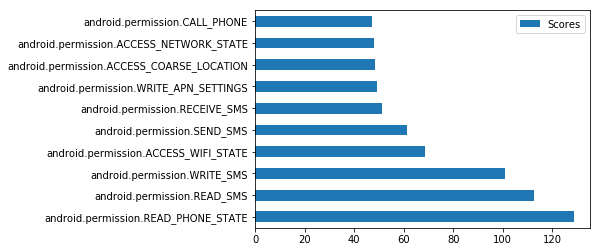

In [31]:
fe = FeatureEngineering()
fe.feature_engineering_one()

## Analysing the results of Feature Engineering 2

In the first technique, we see that 41 columns having greater than 0.6 correlation are removed. And there are 88 columns left from initial 330 columns after selecting the top important features.

Number of columns with greater than 0.6 correlation are 41
Columns with greater than 0.6 correlation are {'android.permission.BLUETOOTH_ADMIN', 'android.permission.FLASHLIGHT', 'android.permission.CHANGE_WIFI_STATE', 'android.permission.WRITE_SYNC_SETTINGS', 'android.permission.SEND_SMS', 'android.permission.MODIFY_PHONE_STATE', 'android.permission.READ_SYNC_SETTINGS', 'android.permission.RECEIVE_MMS', 'android.permission.RESTART_PACKAGES', 'android.permission.READ_EXTERNAL_STORAGE', 'android.permission.USE_CREDENTIALS', 'android.permission.ACCESS_DOWNLOAD_MANAGER', 'android.permission.READ_SYNC_STATS', 'android.permission.ACCESS_DOWNLOAD_MANAGER_ADVANCED', 'android.permission.INTERNET', 'android.permission.WRITE_APN_SETTINGS', 'android.permission.RECEIVE_WAP_PUSH', 'com.android.launcher.permission.WRITE_SETTINGS', 'android.permission.WRITE_CALENDAR', 'android.permission.DISABLE_KEYGUARD', 'android.permission.READ_SMS', 'android.permission.ACCESS_FINE_LOCATION', 'android.permission.SET

,android.permission.ACCESS_CACHE_FILESYSTEM,android.permission.ACCESS_COARSE_LOCATION,android.permission.ACCESS_FINE_LOCATION,android.permission.ACCESS_LOCATION_EXTRA_COMMANDS,android.permission.ACCESS_MOCK_LOCATION,android.permission.ACCESS_NETWORK_STATE,android.permission.ACCESS_WIFI_STATE,android.permission.ACCESS_WIMAX_STATE,android.permission.AUTHENTICATE_ACCOUNTS,android.permission.BATTERY_STATS,...,android.permission.WRITE_SMS,android.permission.WRITE_SYNC_SETTINGS,com.android.alarm.permission.SET_ALARM,com.android.browser.permission.READ_HISTORY_BOOKMARKS,com.android.browser.permission.WRITE_HISTORY_BOOKMARKS,com.android.launcher.permission.INSTALL_SHORTCUT,com.android.launcher.permission.READ_SETTINGS,com.android.launcher.permission.UNINSTALL_SHORTCUT,com.android.launcher.permission.WRITE_SETTINGS,type
0,0,0,0,0,0,1,1,0,0,0,...,1,0,0,0,0,0,0,0,0,1
1,0,0,0,0,0,1,0,0,0,0,...,1,0,0,0,0,0,0,0,0,1
2,0,0,0,0,0,1,0,0,0,0,...,1,0,0,0,0,0,0,0,0,1
3,0,0,0,0,0,1,1,0,0,0,...,1,0,0,0,0,0,0,0,0,1
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
393,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
394,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
395,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
396,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


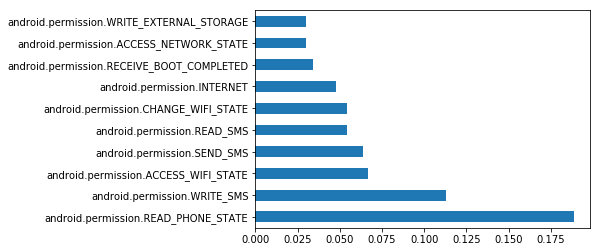

In [32]:
fe = FeatureEngineering()
fe.feature_engineering_two()

## Importing packages to Train Model

In [35]:
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
import xgboost as xgb

In [36]:
estimator_list = {
    "logistic": "LogisticRegression",
    "decision_tree": "tree.DecisionTreeClassifier",
    "naive_bayes":"MultinomialNB",
    "random_forest":"RandomForestClassifier",
    "xgboost": "xgb.XGBClassifier",
    "svc": "SVC"
}

In [37]:
def get_estimators():
    return estimator_list.keys()

## Building pipeline of algorithms

Building a pipeline of algorithms to be used later in the training and evaluation steps.

In [59]:
def load_pipeline(estimator="logistic"):
    if estimator == "logistic":
        pipeline = Pipeline([
            ('clf', LogisticRegression(random_state=19))
        ])
    elif estimator == "decision_tree":
        pipeline = Pipeline([
            ("clf", tree.DecisionTreeClassifier(max_depth=3, random_state=42))
        ])
    elif estimator == "naive_bayes":
        pipeline = Pipeline([
            ('clf', MultinomialNB())
        ])
    elif estimator == "random_forest":
        pipeline = Pipeline([
            ('clf', RandomForestClassifier(n_estimators=1000, oob_score=True, n_jobs=-1,
                                           random_state=50, max_features="auto",
                                           max_leaf_nodes=30))
        ])
    elif estimator == "xgboost":
        pipeline = Pipeline([
            ('clf', xgb.XGBClassifier())
        ])
    elif estimator == "svc":
        pipeline = Pipeline([
            ('clf', SVC(kernel='linear'))
        ])
    else:
        print("estimator unavailable in pipeline")
    return pipeline

## Building the train pipeline

Here we have built the functions to train, evaluate and save the model.

In [64]:
class Trainer:

    def __init__(self, train_test_split_ratio=0.2, estimator="logistic", model_name="malware_detection", choose_best_model=False, choose_feat_eng=None):
        self.train_test_split_ratio = train_test_split_ratio
        if choose_feat_eng is None:
            self.data = ExploratoryAnalysis().remove_correlated_columns(0.5)
        elif choose_feat_eng == "fe1":
            fe = FeatureEngineering()
            self.data = fe.feature_engineering_one()
        elif choose_feat_eng == "fe2":
            fe = FeatureEngineering()
            self.data = fe.feature_engineering_two()
        self.random_state = 101
        self.X = self.data.loc[:, self.data.columns != "type"]
        self.y = self.data.loc[:, self.data.columns == "type"]
        self.train_x, self.test_x, self.train_y, self.test_y = train_test_split(self.X, self.y,
                                                                                test_size=self.train_test_split_ratio,
                                                                                random_state=self.random_state)
        self.estimator = estimator
        self.model_name = model_name
        self.pipeline = None
        self.classification_report_test, self.classification_report_train, self.confusion_matrix_test, self.confusion_matrix_train, self.precision_score, self.recall_score = None, None, None, None, None, None
        self.choose_best_model = choose_best_model

    def train(self):
        """
            select the best algorithm from the different ones available and
            train the model
        """
        if self.choose_best_model is True:
            best_accuracy = 0
            best_estimator = self.estimator
            for estimator in get_estimators():
                self.estimator = estimator
                print("\n Evaluation for estimator *********** ", estimator)
                self.pipeline = load_pipeline(self.estimator)
                print(self.pipeline)
                self.pipeline.fit(self.train_x, self.train_y)
                accuracy = self.eval("accuracy")
                print("Accuracy is = ", accuracy)
                if best_accuracy < accuracy:
                    best_accuracy = accuracy
                    best_estimator = estimator

            print("Chosen best estimator = ", best_estimator, "best accuracy is = ", best_accuracy)
            self.estimator = best_estimator
        self.pipeline = load_pipeline(self.estimator)
        self.pipeline.fit(self.train_x, self.train_y)

    def eval(self, metric=None):
        """
            get all the different evaluation metrics to measure the performance of the model
        """
        predictions_test = self.pipeline.predict(self.test_x)
        predictions_train = self.pipeline.predict(self.train_x)
        accuracy = accuracy_score(self.test_y, predictions_test)
        self.precision_score = precision_score(self.test_y, predictions_test, average='micro')
        self.recall_score = recall_score(self.test_y, predictions_test, average='micro')
        self.classification_report_test = classification_report(self.test_y, predictions_test)
        self.classification_report_train = classification_report(self.train_y, predictions_train)
        self.confusion_matrix_test = confusion_matrix(self.test_y, predictions_test)
        self.confusion_matrix_train = confusion_matrix(self.train_y, predictions_train)
        if metric == None:
            print("\n Accuracy is", accuracy)
            print("Precision", self.precision_score)
            print("Recall", self.recall_score)
            print("\n Train Classification Report \n", self.classification_report_train)
            print("\n Test Classification Report \n", self.classification_report_test)
            print("\n Train Confusion Matrix \n", self.confusion_matrix_train)
            print("\n Test Confusion Matrix \n", self.confusion_matrix_test)
        elif metric == "accuracy":
            return accuracy_score(self.test_y, predictions_test)
        #return self.classification_report_test, self.classification_report_train, self.confusion_matrix_test, self.confusion_matrix_train, self.precision_score, self.recall_score

    def save(self, path=os.getcwd()):
        """
            save the model after training
            :param path: the path where the model needs to be saved
        """
        path = os.path.join(path, "models")
        if not os.path.exists(path):
            os.mkdir(path)
        joblib.dump(self.pipeline, os.path.join(path, 'classifier_' + self.model_name + '.pkl'))

## Performing initial evaluation of data with different algorithms

Initially running the data with no feature engineering and with 6 different algorithms to see which algorithms work best with the given data. The top 2 best algorithms will be selected for model training purposes. 

The algorithms are:
<ol>
    <li>Logistic Regression</li>
    <li>Multinomial Naive Bayes</li>
    <li>Decision Trees Classifier</li>
    <li>Random Forest Classifier</li>
    <li>XGBoost</li>
    <li>SVC</li>
</ol>

Based on the evaluation run, we cann see that the algorithms have the accuracy metrics as follows.
<ol>
    <li>Logistic Regression - 0.9125</li>
    <li>Decision Trees Classifier - 0.9</li>
    <li>Multinomial Naive Bayes - 0.825</li>
    <li>Random Forest Classifier - 0.9125</li>
    <li>XGBoost - 0.925</li>
    <li>SVC - 0.8875</li>
</ol>

Hence we have chosen Random Forest Classifier as our ML1 and XGBoost as our ML2.

In [65]:
tr = Trainer(model_name="malware_detection_no_fe", choose_best_model=True, choose_feat_eng=None)
tr.train()

Number of columns with greater than 0.5 correlation are 48
Columns with greater than 0.5 correlation are {'android.permission.DEVICE_POWER', 'android.permission.RECORD_AUDIO', 'android.permission.BLUETOOTH_ADMIN', 'android.permission.FLASHLIGHT', 'android.permission.CHANGE_WIFI_STATE', 'android.permission.WRITE_SYNC_SETTINGS', 'android.permission.SEND_SMS', 'com.android.launcher.permission.INSTALL_SHORTCUT', 'android.permission.MODIFY_PHONE_STATE', 'android.permission.READ_SYNC_SETTINGS', 'android.permission.RECEIVE_MMS', 'android.permission.RESTART_PACKAGES', 'android.permission.READ_EXTERNAL_STORAGE', 'android.permission.USE_CREDENTIALS', 'android.permission.ACCESS_DOWNLOAD_MANAGER', 'android.permission.READ_SYNC_STATS', 'android.permission.ACCESS_DOWNLOAD_MANAGER_ADVANCED', 'android.permission.INTERNET', 'android.permission.WRITE_APN_SETTINGS', 'android.permission.RECEIVE_WAP_PUSH', 'com.android.launcher.permission.WRITE_SETTINGS', 'android.permission.WRITE_CALENDAR', 'android.permi

## ML1 + FE1

Number of columns with greater than 0.4 correlation are 57
Columns with greater than 0.4 correlation are {'android.permission.DEVICE_POWER', 'android.permission.RECORD_AUDIO', 'android.permission.BLUETOOTH_ADMIN', 'android.permission.FLASHLIGHT', 'android.permission.WRITE_SYNC_SETTINGS', 'android.permission.SEND_SMS', 'com.android.launcher.permission.INSTALL_SHORTCUT', 'android.permission.READ_LOGS', 'android.permission.MODIFY_PHONE_STATE', 'android.permission.READ_SYNC_SETTINGS', 'android.permission.RECEIVE_MMS', 'com.android.launcher.permission.UNINSTALL_SHORTCUT', 'android.permission.RESTART_PACKAGES', 'android.permission.READ_EXTERNAL_STORAGE', 'android.permission.USE_CREDENTIALS', 'android.permission.READ_CALENDAR', 'android.permission.ACCESS_DOWNLOAD_MANAGER', 'android.permission.READ_SYNC_STATS', 'android.permission.ACCESS_DOWNLOAD_MANAGER_ADVANCED', 'android.permission.INTERNET', 'android.permission.GET_PACKAGE_SIZE', 'android.permission.WRITE_APN_SETTINGS', 'android.permission

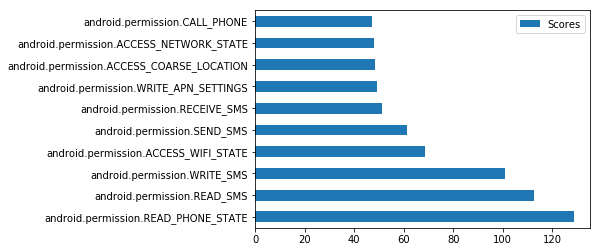

In [50]:
tr = Trainer(estimator="random_forest", model_name="malware_detection_no_fe", choose_best_model=False, choose_feat_eng="fe1")
tr.train()
tr.eval()

## ML2 + FE1

Number of columns with greater than 0.4 correlation are 57
Columns with greater than 0.4 correlation are {'android.permission.DEVICE_POWER', 'android.permission.RECORD_AUDIO', 'android.permission.BLUETOOTH_ADMIN', 'android.permission.FLASHLIGHT', 'android.permission.WRITE_SYNC_SETTINGS', 'android.permission.SEND_SMS', 'com.android.launcher.permission.INSTALL_SHORTCUT', 'android.permission.READ_LOGS', 'android.permission.MODIFY_PHONE_STATE', 'android.permission.READ_SYNC_SETTINGS', 'android.permission.RECEIVE_MMS', 'com.android.launcher.permission.UNINSTALL_SHORTCUT', 'android.permission.RESTART_PACKAGES', 'android.permission.READ_EXTERNAL_STORAGE', 'android.permission.USE_CREDENTIALS', 'android.permission.READ_CALENDAR', 'android.permission.ACCESS_DOWNLOAD_MANAGER', 'android.permission.READ_SYNC_STATS', 'android.permission.ACCESS_DOWNLOAD_MANAGER_ADVANCED', 'android.permission.INTERNET', 'android.permission.GET_PACKAGE_SIZE', 'android.permission.WRITE_APN_SETTINGS', 'android.permission

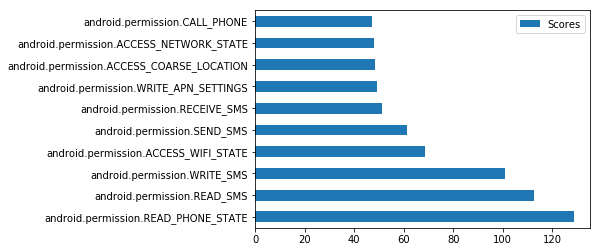

In [51]:
tr = Trainer(estimator="xgboost", model_name="malware_detection_no_fe", choose_best_model=False, choose_feat_eng="fe1")
tr.train()
tr.eval()

## ML1 + FE2

Number of columns with greater than 0.6 correlation are 41
Columns with greater than 0.6 correlation are {'android.permission.BLUETOOTH_ADMIN', 'android.permission.FLASHLIGHT', 'android.permission.CHANGE_WIFI_STATE', 'android.permission.WRITE_SYNC_SETTINGS', 'android.permission.SEND_SMS', 'android.permission.MODIFY_PHONE_STATE', 'android.permission.READ_SYNC_SETTINGS', 'android.permission.RECEIVE_MMS', 'android.permission.RESTART_PACKAGES', 'android.permission.READ_EXTERNAL_STORAGE', 'android.permission.USE_CREDENTIALS', 'android.permission.ACCESS_DOWNLOAD_MANAGER', 'android.permission.READ_SYNC_STATS', 'android.permission.ACCESS_DOWNLOAD_MANAGER_ADVANCED', 'android.permission.INTERNET', 'android.permission.WRITE_APN_SETTINGS', 'android.permission.RECEIVE_WAP_PUSH', 'com.android.launcher.permission.WRITE_SETTINGS', 'android.permission.WRITE_CALENDAR', 'android.permission.DISABLE_KEYGUARD', 'android.permission.READ_SMS', 'android.permission.ACCESS_FINE_LOCATION', 'android.permission.SET

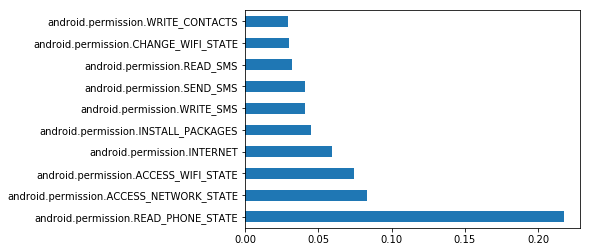

In [52]:
tr = Trainer(estimator="random_forest", model_name="malware_detection_no_fe", choose_best_model=False, choose_feat_eng="fe2")
tr.train()
tr.eval()

## ML2 + FE2

Number of columns with greater than 0.6 correlation are 41
Columns with greater than 0.6 correlation are {'android.permission.BLUETOOTH_ADMIN', 'android.permission.FLASHLIGHT', 'android.permission.CHANGE_WIFI_STATE', 'android.permission.WRITE_SYNC_SETTINGS', 'android.permission.SEND_SMS', 'android.permission.MODIFY_PHONE_STATE', 'android.permission.READ_SYNC_SETTINGS', 'android.permission.RECEIVE_MMS', 'android.permission.RESTART_PACKAGES', 'android.permission.READ_EXTERNAL_STORAGE', 'android.permission.USE_CREDENTIALS', 'android.permission.ACCESS_DOWNLOAD_MANAGER', 'android.permission.READ_SYNC_STATS', 'android.permission.ACCESS_DOWNLOAD_MANAGER_ADVANCED', 'android.permission.INTERNET', 'android.permission.WRITE_APN_SETTINGS', 'android.permission.RECEIVE_WAP_PUSH', 'com.android.launcher.permission.WRITE_SETTINGS', 'android.permission.WRITE_CALENDAR', 'android.permission.DISABLE_KEYGUARD', 'android.permission.READ_SMS', 'android.permission.ACCESS_FINE_LOCATION', 'android.permission.SET

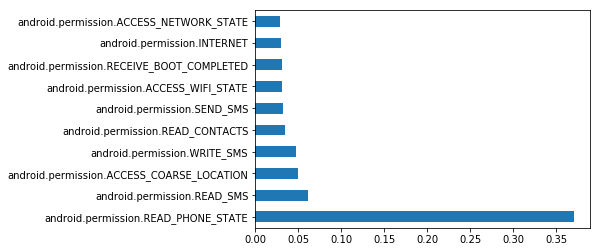

In [53]:
tr = Trainer(estimator="xgboost", model_name="malware_detection_no_fe", choose_best_model=False, choose_feat_eng="fe2")
tr.train()
tr.eval()

## Comparison

Based on the different runs implemented above, we can see that Random forest classifier works best with the data when both feature engineering techniques are applied.

| Machine Learning Technique | Feature Engineering Technique | Accuracy |
| --- | --- | --- |
| Random Forest (ML1) | Correlation (0.4) + SelectKBest (FE1) | 0.925 |
| XGBoost (ML2) | Correlation (0.4) + SelectKBest (FE1) | 0.8875 |
| Random Forest (ML1) | Correlation (0.6) + ExtraTreesClassifier (FE2) | 0.925 |
| XGBoost (ML2) | Correlation (0.6) + ExtraTreesClassifier (FE2) | 0.9 |